In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from itertools import cycle, islice

import warnings
warnings.filterwarnings("ignore")

# Загрузка и предобработка данных

In [2]:
df = pd.read_table('data_banknote_authentication.txt', sep= ',', names= ['variance','skewness','curtosis','entropy','class'])
df

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


Датасет представляет из себя результаты графического анализа подлинных и поддельных банкнот (целевая переменная class). В ходе анализа были получены 4 предиктора - различные характеристики изображения 

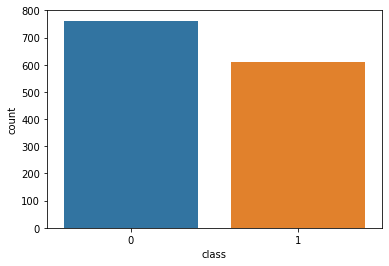

In [3]:
sns.countplot(x='class',data=df)

Выкинем сразу целевую переменную (но держим в голове, что изначально подразумевалось 2 класса)

In [4]:
df.drop(df[['class']], axis=1, inplace=True)
df

,variance,skewness,curtosis,entropy
0,3.62160,8.66610,-2.8073,-0.44699
1,4.54590,8.16740,-2.4586,-1.46210
2,3.86600,-2.63830,1.9242,0.10645
3,3.45660,9.52280,-4.0112,-3.59440
4,0.32924,-4.45520,4.5718,-0.98880
...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949
1368,-1.38870,-4.87730,6.4774,0.34179
1369,-3.75030,-13.45860,17.5932,-2.77710
1370,-3.56370,-8.38270,12.3930,-1.28230


In [5]:
df.describe()

,variance,skewness,curtosis,entropy
count,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657
std,2.842763,5.869047,4.310030,2.101013
min,-7.042100,-13.773100,-5.286100,-8.548200
25%,-1.773000,-1.708200,-1.574975,-2.413450
50%,0.496180,2.319650,0.616630,-0.586650
75%,2.821475,6.814625,3.179250,0.394810
max,6.824800,12.951600,17.927400,2.449500


In [6]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns=['variance','skewness','curtosis','entropy'])

# K-means

Сразу подберём оптимальный параметр k по показателям инерции и силуэта

In [7]:
inertia = []
silhouette = []
k_range = range(2, 10)
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(df)
    inertia.append(km.inertia_)
    silhouette.append(silhouette_score(df, km.labels_))

Text(0, 0.5, 'Инерция')

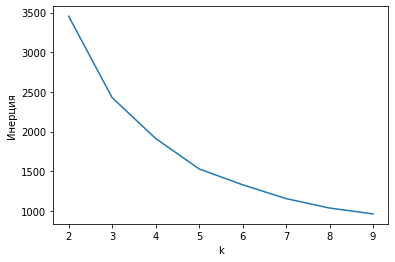

In [8]:
plt.plot(k_range, inertia)
plt.xlabel('k')
plt.ylabel('Инерция')

Text(0, 0.5, 'Силуэт')

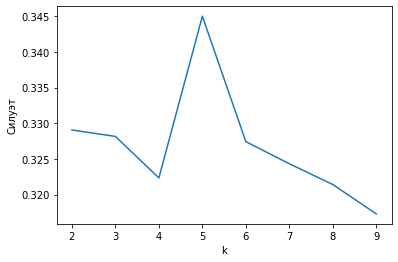

In [9]:
plt.plot(k_range, silhouette)
plt.xlabel('k')
plt.ylabel('Силуэт')

Алгоритм сообщает, что оптимальное количество кластеров = 5
Попробуем визуализировать разбиение на 5 кластеров на проекциях

In [10]:
km = KMeans(n_clusters=5)
km.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

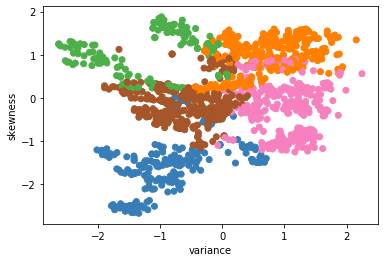

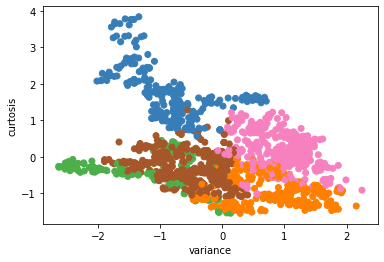

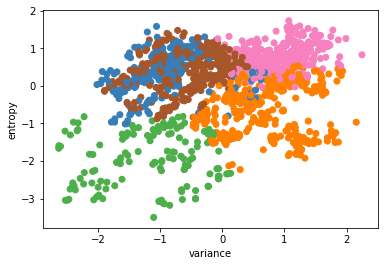

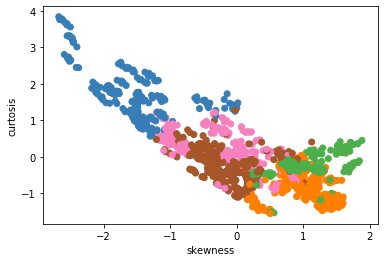

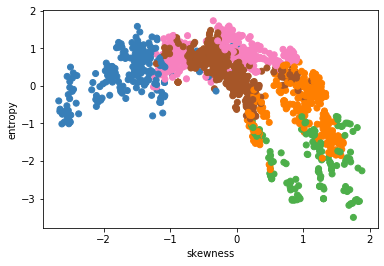

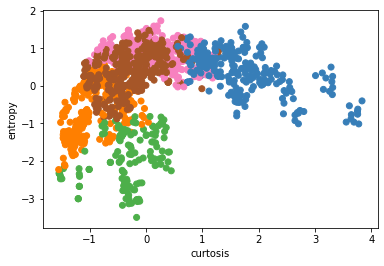

In [11]:
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a', '#f781bf',
                                     '#a65628', '#984ea3', '#999999', '#e41a1c']),
                                      int(max(km.labels_) + 1))))

for col1 in df.columns:
    for col2 in df.columns:
        if df.columns.get_loc(col1) < df.columns.get_loc(col2):
            plt.scatter(df[col1], df[col2], color = colors[km.labels_])
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.show()

По проекциям достаточно тяжело судить, насколько адекватно алгоритм раздал метки кластеров - есть пересечения кластеров, но это лишь проекция - в 4-х мерном пространстве этих пересечений не должно быть

# DBSCAN

Посмотрим как отработает DBSCAN. Сначала возьмём параметры по умолчанию

In [12]:
db = DBSCAN()
db.fit(df)
print('Result -', len(set(db.labels_)),'clusters:', set(db.labels_))

Result - 9 clusters: {0, 1, 2, 3, 4, 5, 6, 7, -1}


Алгоритм разделил наши данные на 9 кластеров, есть кластер с выбросами

Теперь переберём входные параметры алгоритма и визуализируем оценку силуэт для каждой пары

In [13]:
silhouettes = []
silhouette = []
epsilon_range = np.arange(0.15, 0.85, 0.1)
samples_range = range(1, 8, 1)
for epsilon in epsilon_range:
    for samles in samples_range:
        db = DBSCAN(eps=epsilon, min_samples=samles)
        db.fit(df)
        silhouette.append(silhouette_score(df, db.labels_))
        n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
        n_noise_ = list(db.labels_).count(-1)
        print(f'Epsilon: {epsilon:.2f}, samples: {samles}'
              f'\nClusters count: {n_clusters_}, noise: {n_noise_}, silhouette score: {silhouette_score(df, db.labels_)}'
              f'\n-------------------------------')
    silhouettes.append(silhouette)
    silhouette = []

Epsilon: 0.15, samples: 1
Clusters count: 607, noise: 0, silhouette score: 0.21744286108800254
-------------------------------
Epsilon: 0.15, samples: 2
Clusters count: 223, noise: 384, silhouette score: 0.0979024827894751
-------------------------------
Epsilon: 0.15, samples: 3
Clusters count: 154, noise: 522, silhouette score: 0.0040828521267334515
-------------------------------
Epsilon: 0.15, samples: 4
Clusters count: 80, noise: 794, silhouette score: -0.22160766270146015
-------------------------------
Epsilon: 0.15, samples: 5
Clusters count: 53, noise: 963, silhouette score: -0.34335417897847464
-------------------------------
Epsilon: 0.15, samples: 6
Clusters count: 27, noise: 1127, silhouette score: -0.4465716102861937
-------------------------------
Epsilon: 0.15, samples: 7
Clusters count: 18, noise: 1213, silhouette score: -0.5050303145353401
-------------------------------
Epsilon: 0.25, samples: 1
Clusters count: 158, noise: 0, silhouette score: 0.10751413411086701
---

Text(1, 2.15, 'Maximum silhouette (0.22) params:\nepsilon = 1, samples = 0.15')

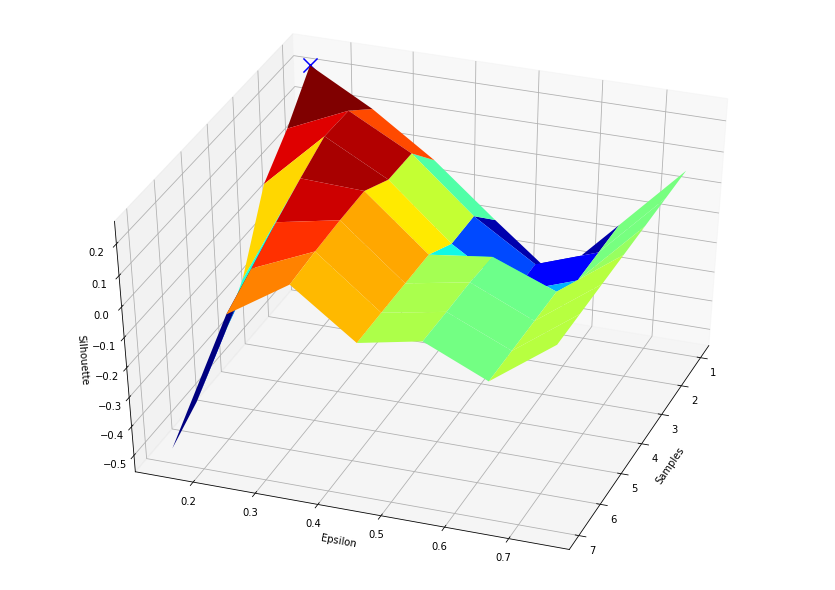

In [14]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(samples_range, epsilon_range)
Z = np.array(silhouettes)
xmax_index, ymax_index = np.unravel_index(np.argmax(Z), Z.shape)
xmax = X[xmax_index, ymax_index]
ymax = Y[xmax_index, ymax_index]
zmax = Z.max()
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=40, azim=20)
ax.plot_surface(X, Y, Z, cmap= 'jet')
ax.set_xlabel('Samples')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Silhouette')
ax.scatter(xmax, ymax, zmax, marker="x", s= 200, c= 'blue')
ax.text(xmax, ymax + 2, zmax+0.1, 
        s = f'Maximum silhouette ({zmax:.2f}) params:\n' 
            f'epsilon = {xmax}, samples = {ymax}', 
        color='blue')

На полученных данных видим, что максимальное значение оценки силуэта достигается при минимальных epsilon и samples, но при этом алгоритм делит наблюдения на большое число кластеров = 607, за счёт чего и достигается эта оценка

Также можем видеть, что оценка снижается при увеличении входных параметров, при этом уменьшается и количество кластеров. Однако, при epsilon = 0,75 оценка силуэта вновь возрастает и и держится на уровне ~ 0.06 для любого значения samples, при этом число кластеров = 2, что соответствует изначальной постановке (2 целевых класса - подлинные и поддельные купюры)